In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
TIME_STEP_LENGTH = 0.001

N_POINTS = 128
DOMAIN_SIZE = 1.0 #m
N_ITERATIONS = 5000
nu = 0.1 #nu=mu/rho - kinematic viscosity, m2/sec
rho = 1.0 #density, g/m3
mu = nu*rho
HORIZONTAL_VELOCITY_TOP = 1.0 #m/s

N_PRESSURE_POISSON_ITERATIONS = 50
C = 0.5 #CFL
umax = 10
pout = 100

# for force
G=1 #momentum
r = 0.25 * DOMAIN_SIZE #force size
xp = 0.5 * DOMAIN_SIZE
yp = 0.5 * DOMAIN_SIZE


100%|██████████| 5000/5000 [00:13<00:00, 359.38it/s]


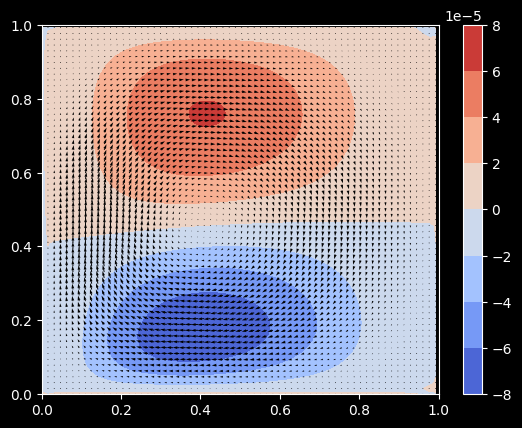

-7.622582522101194e-05 6.103454561222686e-05


In [3]:
def main(G, r, xp, yp):
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    dt = (0.5 * element_length**2 / nu)*C
    X, Y = np.meshgrid(x, y)

    def central_difference_x(f): #First order derivative df/dx: 2-points stencil
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 2:]-f[1:-1, 0:-2]) / (2 * element_length)
        return diff

    def central_difference_y(f): #First order derivative df/dy: 2-points stencil
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[2:, 1:-1]-f[0:-2, 1:-1]) / (2 * element_length)
        return diff

    def laplace(f): #Sum of second order derivatives: 5-points stencil
        diff = np.zeros_like(f)
        diff[1:-1, 1:-1] = (f[1:-1, 0:-2]+f[0:-2, 1:-1]-4*f[1:-1, 1:-1]+f[1:-1, 2:]+f[2:, 1:-1]) / (element_length**2)
        return diff

    def velocity_parabola(y, umax): #Parabolic shape (y=0 -> u=0; y=y.max() -> u=0; y=y.max()/2 -> u=umax)
        return 4*umax/(y.max()**2)*y*(y.max()-y)

    def force(x, y):
      f = np.zeros((N_POINTS, N_POINTS))
      for ix, xv in enumerate(x):
        for iy, yv in enumerate(y):
          vexp=-1*((xv-xp)**2+(yv-yp**2))/r
          f[ix, iy]=G*np.exp(vexp)
      return f*TIME_STEP_LENGTH

    F = force(x, y)


    maximum_possible_time_step_length = (0.5 * element_length**2 / nu) #CFL for heat transfer problem
    if dt > C * maximum_possible_time_step_length:
        raise RuntimeError("Stability is not guarenteed")

    u_prev = np.zeros_like(X)
    v_prev = np.zeros_like(X)
    p_prev = np.zeros_like(X)


    for _ in tqdm(range(N_ITERATIONS)):
        du_dx = central_difference_x(u_prev)
        du_dy = central_difference_y(u_prev)
        dv_dx = central_difference_x(v_prev)
        dv_dy = central_difference_y(v_prev)
        laplace_u = laplace(u_prev)
        laplace_v = laplace(v_prev)

        # Perform a tentative step by solving the momentum equation without the pressure gradient.
        # Euler method: df/dt = f_i-f_(i-1)/dt -> df/dt=x -> f_i=(f_i-1)+xdt
        u_tent = (u_prev + dt * (- (u_prev * du_dx + v_prev * du_dy) + nu * laplace_u +F))
        v_tent = (v_prev + dt * (- (u_prev * dv_dx + v_prev * dv_dy) + nu * laplace_v +F))

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_tent[0, :] = -u_tent[1, :]
        u_tent[:, 0] = -u_tent[:, 1]
        u_tent[:, -1] = -u_tent[:, -2]
        u_tent[-1, :] = -u_tent[-2, :]
        v_tent[0, :] = -v_tent[1, :]
        v_tent[:, 0] = -v_tent[:, 1]
        v_tent[:, -1] = -v_tent[:, -2]
        v_tent[-1, :] = -v_tent[-2, :]



        du_tent_dx = central_difference_x(u_tent)
        dv_tent_dy = central_difference_y(v_tent)

        # Compute a pressure correction by solving the pressure-poisson equation
        rhs = (rho / dt * (du_tent_dx + dv_tent_dy))

        for _ in range(N_PRESSURE_POISSON_ITERATIONS):

            p_next = np.zeros_like(p_prev)
            p_next[1:-1, 1:-1] = 1/4 * (p_prev[1:-1, 0:-2]+p_prev[0:-2, 1:-1]+p_prev[1:-1, 2:]+p_prev[2:, 1:-1]
                                 - element_length**2 * rhs[1:-1, 1:-1] )

            # Pressure Boundary Conditions
            p_next[:, -1] = p_next[:, -2]
            p_next[0,  :] = p_next[1,  :]
            p_next[:,  0] = p_next[:,  1]
            p_next[-1, :] = p_next[-2, :]

            p_prev = p_next


        dp_next_dx = central_difference_x(p_next)
        dp_next_dy = central_difference_y(p_next)

        # Correct the velocities such that the fluid stays incompressible
        u_next = (u_tent - dt / rho * dp_next_dx)
        v_next = (v_tent - dt / rho * dp_next_dy)

        # Velocity Boundary Conditions: Homogeneous Dirichlet BC everywhere
        # except for the horizontal velocity at the top, which is prescribed
        u_next[0, :] = -u_next[1, :]
        u_next[:, 0] = -u_next[:, 1]
        u_next[:, -1] = -u_next[:, -2]
        u_next[-1, :] = -u_next[-2, :]
        v_next[0, :] = -v_next[1, :]
        v_next[:, 0] = -v_next[:, 1]
        v_next[:, -1] = -v_next[:, -2]
        v_next[-1, :] = -v_next[-2, :]




        # Advance in time
        u_prev = u_next
        v_prev = v_next
        p_prev = p_next


    # The [::2, ::2] selects only every second entry (less cluttering plot)
    plt.style.use("dark_background")
    plt.figure()
    plt.contourf(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], cmap="coolwarm")
    plt.colorbar()

    plt.quiver(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    # plt.streamplot(X[::2, ::2], Y[::2, ::2], u_next[::2, ::2], v_next[::2, ::2], color="black")
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.show()

    print(u_next.min(), u_next.max())
    return u_next, v_next, p_next
for i in range(1):
  u_big, v_big, p_big = main(G, r, xp, yp)

100%|██████████| 5000/5000 [00:05<00:00, 876.77it/s]


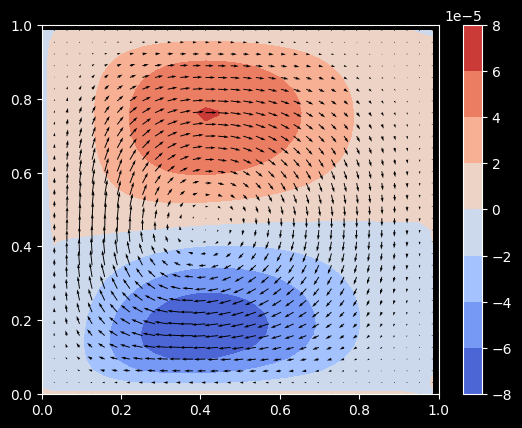

-7.50546091541943e-05 6.044850780206634e-05


In [4]:
N_POINTS = 64
u_min, v_min, p_min = main(G, r, xp, yp)